In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import sys
import pandas as pd

import pickle
import glob
import re
import yaml
import torch
import json

In [86]:
def find_params(data, cond):
    for d in data:
        found = True
        for k, v in cond.items():
            if d["args"][k] != v:
                found = False
        if found:
            return d
    return None

def find_all_params(data, cond):
    all_d = []
    for d in data:
        found = True
        for k, v in cond.items():
            if d["args"][k] != v:
                found = False
        if found:
            all_d.append(d)
    return all_d

def load_data(root):
    data = []
    total = 0
    folders = sorted(glob.glob(os.path.join(root, "*")))
    last_prefix = None

    for folder in folders:
        path, folder_name = os.path.split(folder)
        prefix, job_id = folder_name.split("_")
        if prefix == last_prefix:
            continue

        args = yaml.load(open(os.path.join(folder, "config.yaml"), "r"))
        filename = os.path.join(folder, "stats.pickle")
        if os.path.exists(filename):
            print(f"{len(data)}: {folder}")
            stats = torch.load(filename)
            data.append(dict(args=args,stats=stats))
            last_prefix = prefix
            
    return data

# With pruning. 
root = "/checkpoint/yuandong/outputs/2019-09-22/20-30-29"
suffix = "with_pruning"

# Without pruning
#root = "/checkpoint/yuandong/outputs/2019-09-24/00-30-19"
root = "/checkpoint/yuandong/outputs/2019-09-29/15-03-51"
suffix = "without_pruning"

data = load_data(root)


0: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/0_18137342
1: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/10_18137352
2: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/11_18137353
3: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/12_18137355
4: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/13_18137358
5: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/14_18137361
6: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/15_18137365
7: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/16_18137369
8: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/17_18137372
9: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/18_18137373
10: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/19_18137374
11: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/1_18137343
12: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/20_18137375
13: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/21_18137376
14: /checkpoint/yuandong/outputs/2019-09-29/15-03-51/22_18137377
15: /checkpoint/yuandong/outputs/2019

In [88]:
if suffix == "with_pruning":
    model_path = "/private/home/yuandong/dl_theory2/pytorch-cifar/checkpoint/ckpt_84.21_pruned.pt"
    inactive_nodes = teacher["inactive_nodes"]
else:
    model_path = "/private/home/yuandong/dl_theory2/pytorch-cifar/checkpoint/ckpt_86.09.t7"
    inactive_nodes = [list() for i in range(4)]

teacher = torch.load(model_path)


multi = 1
multi = 2
multi = 5


ZeroDivisionError: float division by zero

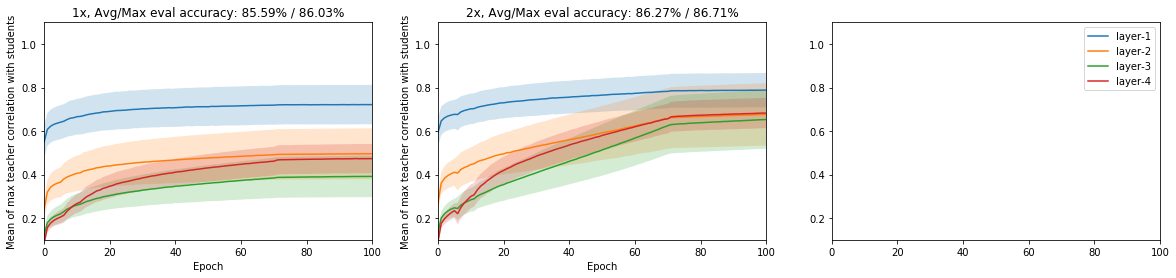

In [89]:
counter = 1
plt.figure(figsize=(20,4))
for multi in (1, 2, 5):
    plt.subplot(1, 3, counter)
    counter += 1
    print(f"multi = {multi}")

    ds = find_all_params(data, dict(node_multi=multi))

    all_eval_loss = []
    all_train_loss = []

    n_layer = len(inactive_nodes)

    active_nodes = [None] * n_layer
    avg_max_corrs = [None] * n_layer
    avg_max_corrs_sqr = [None] * n_layer
    avg_max_counts = [None] * n_layer

    for layer_idx, inactive in enumerate(inactive_nodes):
        active_nodes[layer_idx] = list(set(range(64)) - set(inactive))
        n_active = len(active_nodes[layer_idx])
        avg_max_corrs[layer_idx] = torch.FloatTensor(n_active, 101).fill_(0)
        avg_max_corrs_sqr[layer_idx] = torch.FloatTensor(n_active, 101).fill_(0)
        avg_max_counts[layer_idx] = torch.FloatTensor(101).fill_(0)


    avg_acc = 0.0
    max_acc = 0.0
    avg_acc_count = 0

    # print(len(ds))
    for d in ds:
        for trial in d["stats"]:
            if trial[-1].get("exit", None) == "nan":
                continue
                
            best_accuracy = 0

            for epoch, s in enumerate(trial):
                for layer_idx, corr in enumerate(s["eval_corrs"]):
                    n_student, n_teacher = corr.size()
                    active = active_nodes[layer_idx]
                    max_corr = corr[:, active].max(dim=0)[0]
                    avg_max_corrs[layer_idx][:, epoch] += max_corr
                    avg_max_corrs_sqr[layer_idx][:, epoch] += max_corr.pow(2)
                    avg_max_counts[layer_idx][epoch] += 1
                    
                best_accuracy = max(best_accuracy, s["eval_accuracy"])
                    
            avg_acc += best_accuracy
            avg_acc_count += 1
            
            if max_acc < best_accuracy:
                max_acc = best_accuracy

    for layer_idx in range(n_layer):
        counts = avg_max_counts[layer_idx][None, :]
        corr = avg_max_corrs[layer_idx] / counts
        std = (avg_max_corrs_sqr[layer_idx] / counts - corr.pow(2)).sqrt()

        x = list(range(101))

        corr = corr.mean(dim=0).numpy()
        std = std.mean(dim=0).numpy()

        plt.plot(x, corr, label=f"layer-{layer_idx + 1}")
        plt.fill_between(x, corr - std, corr + std, alpha=0.2)

    if multi == 5:
        plt.legend()
    plt.axis([0, 100, 0.1, 1.1])
    plt.title(f"{multi}x, Avg/Max eval accuracy: {avg_acc / avg_acc_count:#.2f}% / {max_acc:.2f}%")
    plt.ylabel('Mean of max teacher correlation with students')
    plt.xlabel("Epoch")

plt.savefig(f"mean_correlation_cifar10_{suffix}.pdf")
# plt.show()

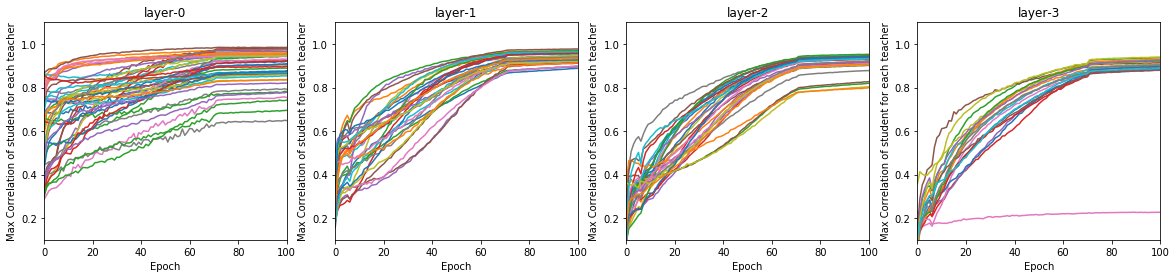

In [69]:
counter = 1
plt.figure(figsize=(20,4))
for layer_idx in range(n_layer):
    plt.subplot(1, 4, counter)
    counter += 1
    counts = avg_max_counts[layer_idx][None, :]
    corr = avg_max_corrs[layer_idx] / counts
    std = (avg_max_corrs_sqr[layer_idx] / counts - corr.pow(2)).sqrt()
    
    n_teacher, n_epoch = corr.size()
    x = list(range(n_epoch))
    for i in range(n_teacher):
        plt.plot(x, corr[i,:].numpy())
        # plt.fill_between(x, (corr[i,:] - std[i,:]).numpy(), (corr[i,:] + std[i,:]).numpy(), alpha=0.05)
        
    plt.axis([0, 100, 0.1, 1.1])
    plt.title(f"layer-{layer_idx}")
    plt.ylabel('Max Correlation of student for each teacher')
    plt.xlabel("Epoch")

plt.savefig("max_correlation_per_teacher.pdf")
# plt.show()

In [44]:
corr.size()

torch.Size([20, 101])

In [13]:
teacher["inactive_nodes"]

[[31, 26, 21, 23, 4, 5, 34, 33, 47, 44, 42, 39, 52, 3, 2, 9, 62, 49, 63],
 [31,
  30,
  28,
  27,
  21,
  20,
  22,
  23,
  18,
  16,
  2,
  4,
  11,
  9,
  12,
  14,
  7,
  44,
  41,
  40,
  34,
  33,
  38,
  39,
  32,
  45,
  53,
  51,
  59,
  58,
  61,
  63],
 [31,
  27,
  24,
  22,
  16,
  17,
  21,
  3,
  7,
  6,
  9,
  10,
  11,
  13,
  14,
  15,
  2,
  1,
  4,
  41,
  34,
  32,
  37,
  38,
  46,
  45,
  48,
  50,
  56,
  60,
  62,
  63],
 [30,
  29,
  28,
  27,
  26,
  25,
  21,
  20,
  19,
  18,
  17,
  33,
  35,
  34,
  37,
  38,
  46,
  45,
  44,
  43,
  2,
  1,
  4,
  3,
  6,
  5,
  9,
  10,
  11,
  12,
  13,
  14,
  54,
  53,
  52,
  51,
  42,
  36,
  50,
  49,
  59,
  58,
  61,
  60]]

In [ ]:
/checkpoint/yuandong/outputs/2019-09-29/15-03-51/